In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Objective:
Train an NLP based **classification model** to detect whether the news is **Real** or **Fake**.

# Loading the Dataset:

In [2]:
df = pd.read_csv("WELFake_Dataset.csv")
df.head(5)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Dropping Unnecessary Columns:

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
# Drop rows with missing text (only ~39 rows)
df = df.dropna(subset=['text'])

In [6]:
# Fill missing titles with empty string
df['title'] = df['title'].fillna('')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   72095 non-null  object
 1   text    72095 non-null  object
 2   label   72095 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


# Exploratory Data Analysis:

In [9]:
# Set a clean style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

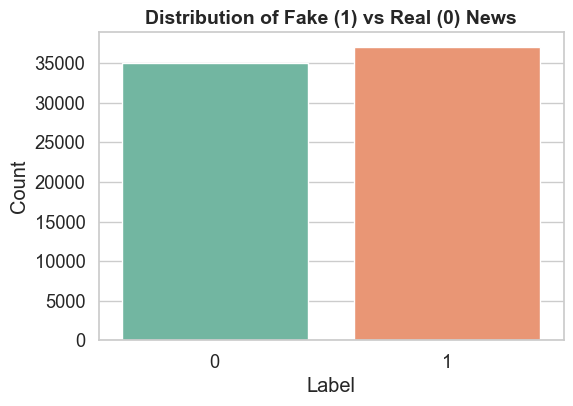

In [11]:
# Label Distribution

plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette="Set2", hue = df['label'], legend = False)
plt.title("Distribution of Fake (1) vs Real (0) News", fontsize=14, weight='bold')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

There is almost **equal** number of both Real and Fake news. So the distribution is almost **Uniform**.

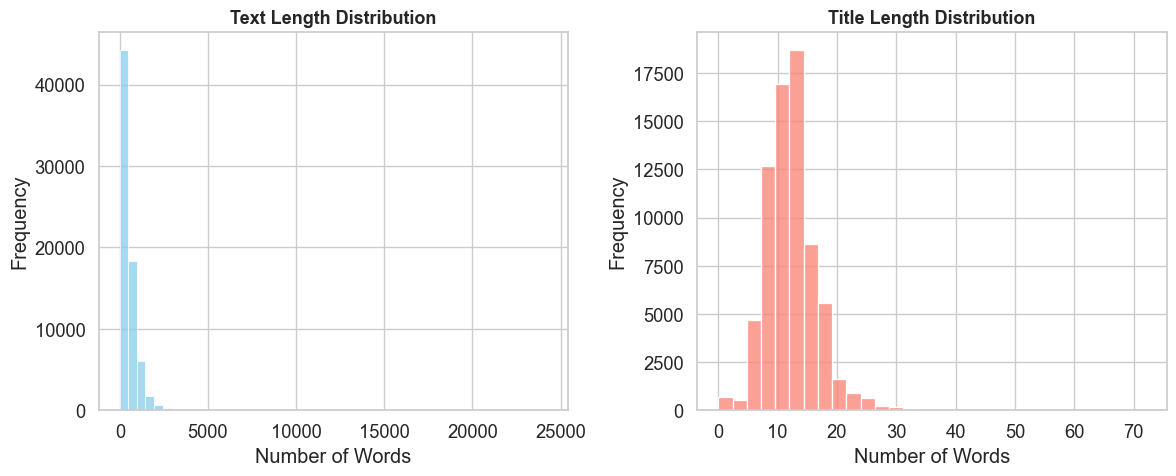

In [12]:
# Text Length Distribution

df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df['title_len'] = df['title'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df['text_len'], bins=50, ax=axes[0], color="skyblue")
axes[0].set_title("Text Length Distribution", fontsize=13, weight='bold')
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Frequency")

sns.histplot(df['title_len'], bins=30, ax=axes[1], color="salmon")
axes[1].set_title("Title Length Distribution", fontsize=13, weight='bold')
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

1. The length of title is ranging from **0-30** words. With most of the titles ranging from **10** to **20** words.
2. The length of text description is ranging from **0-2500** words. Most of them lie in the range **0-1000** words.

In [15]:
from wordcloud import WordCloud

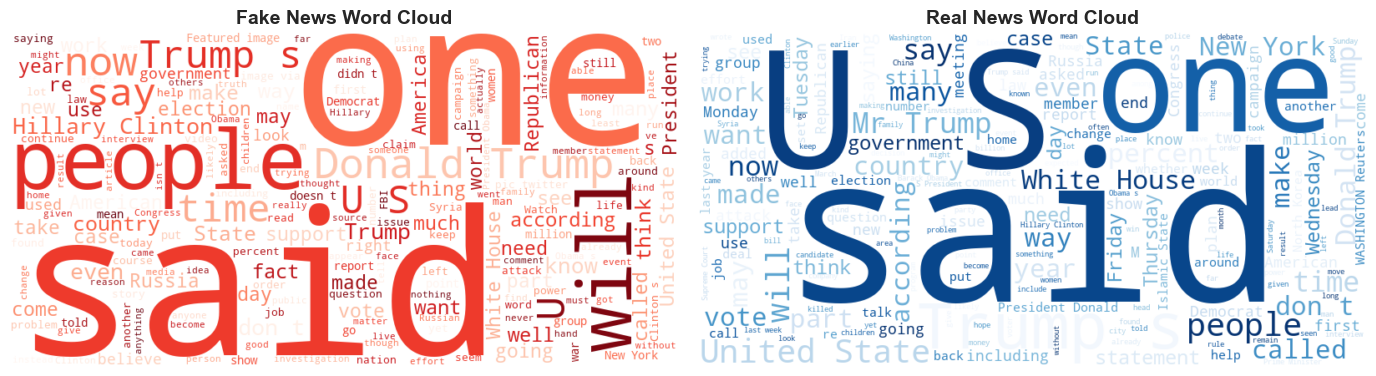

In [16]:
# Word Clouds.

fake_text = " ".join(df[df['label']==1]['text'])
real_text = " ".join(df[df['label']==0]['text'])

wc_fake = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(real_text)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].imshow(wc_fake, interpolation="bilinear")
axes[0].set_title("Fake News Word Cloud", fontsize=14, weight='bold')
axes[0].axis("off")

axes[1].imshow(wc_real, interpolation="bilinear")
axes[1].set_title("Real News Word Cloud", fontsize=14, weight='bold')
axes[1].axis("off")

plt.tight_layout()
plt.show()

1. The most used words in the **Fake News WordCloud** are **said, will, people, one, Trumps** etc.
2. The most used words in the **Real News WordCloud** are **US, said, one, people, White House, government** etc.

# Preprocessing the Data:

In [17]:
# Combine title and text into one column
df['content'] = df['title'] + " " + df['text']

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      72095 non-null  object
 1   text       72095 non-null  object
 2   label      72095 non-null  int64 
 3   text_len   72095 non-null  int64 
 4   title_len  72095 non-null  int64 
 5   content    72095 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


# Dropping some unnecessary columns and saving for reference:

In [19]:
# Columns to keep for reference
df_ref = df[['title', 'text', 'text_len', 'title_len']].copy()

# Columns for modeling
df_model = df[['content', 'label']].copy()

# Saving the current preprocessed data to Disk:

In [20]:
# Save training dataframe
df_model.to_parquet("df_model.parquet", index=False)

# Save reference dataframe
df_ref.to_parquet("df_ref.parquet", index=False)

print("✅ DataFrames saved successfully to disk.")

✅ DataFrames saved successfully to disk.


# Reading the current preprocessed data from Disk:

In [2]:
# Load training dataframe
df_model = pd.read_parquet("df_model.parquet")

# Load reference dataframe
df_ref = pd.read_parquet("df_ref.parquet")

print("✅ DataFrames loaded successfully from disk.")

✅ DataFrames loaded successfully from disk.


In [3]:
print("df_model shape:", df_model.shape)
print("df_ref shape:", df_ref.shape)

df_model shape: (72095, 2)
df_ref shape: (72095, 4)


# Train/Test Split:

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# X = features (content), y = target (label)
X = df_model['content']
y = df_model['label']

In [6]:
# Train-test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [7]:
print("✅ Data split completed.")
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

✅ Data split completed.
Train set size: 57676
Test set size: 14419


# Further Preprocessing:

In [8]:
import re
import spacy
import nltk
from nltk.corpus import stopwords

In [9]:
# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HASHIR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [11]:
# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [12]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove punctuation, digits, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize + 4. Remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    
    # 5. Lemmatization with spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return " ".join(tokens)

In [13]:
# Testing
print(preprocess_text("Trump's running quickly in 2020 Elections!!!"))

trump run quickly election


In [14]:
# Apply preprocessing to train and test sets
X_train_clean = X_train.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

print("✅ Preprocessing complete.")

✅ Preprocessing complete.


# TF-IDF Vectorization:

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,      
    ngram_range=(1,2),       # unigrams + bigrams
    stop_words='english'    
)

In [17]:
# Fit on training data and transform
X_train_tfidf = tfidf.fit_transform(X_train_clean)

In [18]:
# Transform test data
X_test_tfidf = tfidf.transform(X_test_clean)

In [19]:
print("✅ TF-IDF transformation complete.")
print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

✅ TF-IDF transformation complete.
Train shape: (57676, 10000)
Test shape: (14419, 10000)


# Saving Raw Preprocesed Text to Parquet Files:

In [20]:
train_processed = pd.DataFrame({
    "content": X_train_clean,
    "label": y_train.reset_index(drop=True)
})

test_processed = pd.DataFrame({
    "content": X_test_clean,
    "label": y_test.reset_index(drop=True)
})

train_processed.to_parquet("train_processed.parquet", index=False)
test_processed.to_parquet("test_processed.parquet", index=False)

print("✅ Preprocessed train/test text saved.")

✅ Preprocessed train/test text saved.


# Saving TF-IDF Vectorized Data to Disk:

In [22]:
import joblib

In [23]:
joblib.dump(X_train_tfidf, "X_train_tfidf.pkl")
joblib.dump(X_test_tfidf, "X_test_tfidf.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")

# Save the fitted TF-IDF vectorizer so you can transform new text later
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ TF-IDF features and vectorizer saved.")

✅ TF-IDF features and vectorizer saved.


# Reading Raw Preprocesed Text from Parquet Files:

In [24]:
# Reload preprocessed text
train_processed = pd.read_parquet("train_processed.parquet")
test_processed = pd.read_parquet("test_processed.parquet")

X_train_clean, y_train = train_processed["content"], train_processed["label"]
X_test_clean, y_test = test_processed["content"], test_processed["label"]

# Reading TF-IDF Vectorized Data from Disk:

In [25]:
# Reload TF-IDF features
X_train_tfidf = joblib.load("X_train_tfidf.pkl")
X_test_tfidf = joblib.load("X_test_tfidf.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

print("✅ Data and TF-IDF vectorizer loaded successfully.")

✅ Data and TF-IDF vectorizer loaded successfully.
